In [1]:
# load on merge data sources
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
!pip install pybaseball # Added ! to run this line as a shell command.
import pybaseball as pyb
from pybaseball import statcast
from pybaseball import statcast_batter_expected_stats
from scipy import stats
import itertools
import numpy as np

aa = pd.read_csv("EVI_CQ.csv", usecols=["batter","Name","Year","AA_Rnk"])
vba = pd.read_csv("VBA_All.csv", usecols=["batter","2023"])
sav = pd.read_csv("statcast.csv")
dfpitch = pd.read_csv("pstatcast.csv")

aa = aa[aa['Year'] == 2023]
vba = vba.dropna()
aa=aa.dropna()


df = pd.merge(aa, vba, on="batter", how="inner")
df.rename(columns={"2023": "VBA"}, inplace=True)

print(df.head())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 33.8 MB/s eta 0:00:00
   batter             Name  Year  AA_Rnk   VBA
0  543305      Aaron Hicks  2023      28  27.8
1  592450      Aaron Judge  2023      98  41.3
2  594807      Adam Duvall  2023     100  29.5
3  624428     Adam Frazier  2023      84  36.1
4  668939  Adley Rutschman  2023      51  35.9


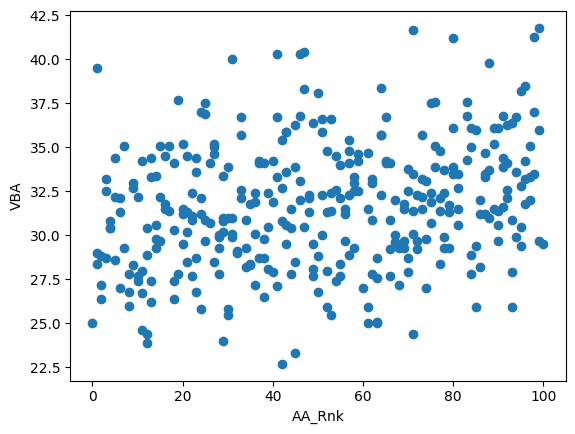

In [2]:
#Scatter VBA and AA
plt.scatter(df["AA_Rnk"], df["VBA"])
plt.xlabel("AA_Rnk")
plt.ylabel("VBA")
plt.show()

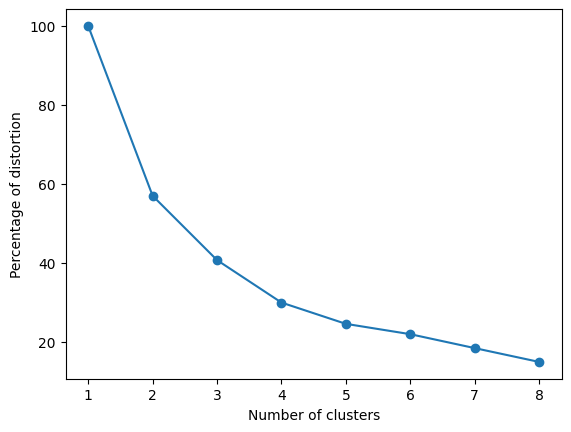

In [3]:
#K mean clustering
data = df[["AA_Rnk", "VBA"]].copy()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
distortions = []

for i in range(1, 9):
            kmeans = KMeans(n_clusters=i, random_state=6740, n_init='auto')
            kmeans.fit(scaled_data)
            distortions.append(kmeans.inertia_)

#plot elbow curve
max_distortion = distortions[0]
percentage_distortions = [(d / max_distortion) * 100 for d in distortions]
plt.plot(range(1, 9), percentage_distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Percentage of distortion')
plt.show()

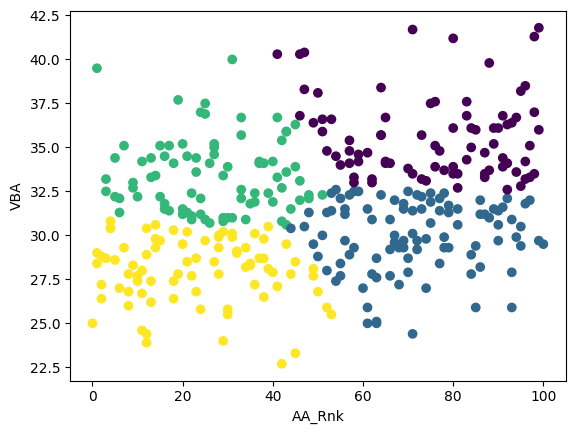

   batter             Name  Year  AA_Rnk   VBA  cluster
0  543305      Aaron Hicks  2023      28  27.8        3
1  592450      Aaron Judge  2023      98  41.3        0
2  594807      Adam Duvall  2023     100  29.5        1
3  624428     Adam Frazier  2023      84  36.1        0
4  668939  Adley Rutschman  2023      51  35.9        0


In [4]:
kmeans = KMeans(n_clusters=4, random_state=6740, n_init='auto')
df['cluster'] = kmeans.fit_predict(scaled_data)
plt.scatter(df['AA_Rnk'], df['VBA'], c=df['cluster'])
plt.xlabel('AA_Rnk')
plt.ylabel('VBA')
plt.show()

df['cluster'] = kmeans.fit_predict(scaled_data)
print(df.head())

In [5]:
'''
d1 = statcast(start_dt='2023-01-01', end_dt='2023-12-06',verbose=False)
useful = ['pitch_type','batter','pitcher','zone','stand','p_throws','type','estimated_woba_using_speedangle'] #excluding pitch characterisitcs
df1 = d1[useful]
df1 = df1[df1['type']=='X']
df1= df1[df1['batter'].isin(df['batter'])]
print(df1.head())
print(df1.shape)
df1.to_csv('statcast.csv', index=False)
'''
'''
dfpitch = statcast(start_dt='2023-01-01', end_dt='2023-12-02',verbose=False)
useful = ['pitch_type','batter','pitcher','zone','stand','p_throws'] #excluding pitch characterisitcs
dfpitch = dfpitch[useful]
dfpitch = dfpitch[dfpitch['p_throws']=='R']
dfpitch = dfpitch[dfpitch['stand']=='R']
dfpitch['remapped_zone'] = dfpitch['zone'].map(zone_mapping)
print(dfpitch.head())
dfpitch.to_csv('pstatcast.csv', index=False)
'''

"\nd1 = statcast(start_dt='2023-01-01', end_dt='2023-12-06',verbose=False)\nuseful = ['pitch_type','batter','pitcher','zone','stand','p_throws','type','estimated_woba_using_speedangle'] #excluding pitch characterisitcs\ndf1 = d1[useful]\ndf1 = df1[df1['type']=='X']\ndf1= df1[df1['batter'].isin(df['batter'])]\nprint(df1.head())\nprint(df1.shape)\ndf1.to_csv('statcast.csv', index=False)\n"

In [6]:
#take mean estimated_woba grouped by batter, pitch_type, p_throws
df2 = sav.groupby(['batter', 'pitch_type', 'p_throws']).agg(
    pitch_xWOBACON=('estimated_woba_using_speedangle', 'mean'),  # Calculate mean
    count=('estimated_woba_using_speedangle', 'size')  # Calculate count
).reset_index()

batter_agg = sav.groupby('batter').agg(
            season_xWOBACON=('estimated_woba_using_speedangle', 'mean'),
            batter_count=('estimated_woba_using_speedangle', 'size')
        ).reset_index()

df2 = pd.merge(df2, batter_agg, on='batter', how='left')


#remove rows with count less than 10, only RHP
df2 = df2[df2['p_throws']=='R']
df2 = df2[df2['count'] >= 10]
df3 = pd.merge(df2, df, on="batter", how="left")
df3.head()

dfzone = sav.groupby(['batter', 'zone', 'p_throws']).agg(
    pitch_xWOBACON=('estimated_woba_using_speedangle', 'mean'),  # Calculate mean
    count=('estimated_woba_using_speedangle', 'size')  # Calculate count
).reset_index()

dfzone = pd.merge(dfzone, batter_agg, on='batter', how='left')
dfzone = pd.merge(dfzone, df, on="batter", how="left")
dfzone = dfzone[dfzone['p_throws']=='R']
dfzone = dfzone[dfzone['count'] >= 10]
dfzone.head()

print(dfzone.head())

    batter  zone p_throws  pitch_xWOBACON  count  season_xWOBACON  \
3   408234   2.0        R        0.526923     13          0.33657   
7   408234   4.0        R        0.282545     25          0.33657   
9   408234   5.0        R        0.340889     27          0.33657   
11  408234   6.0        R        0.380714     22          0.33657   
13  408234   7.0        R        0.322308     13          0.33657   

    batter_count            Name  Year  AA_Rnk   VBA  cluster  
3            273  Miguel Cabrera  2023      10  32.2        2  
7            273  Miguel Cabrera  2023      10  32.2        2  
9            273  Miguel Cabrera  2023      10  32.2        2  
11           273  Miguel Cabrera  2023      10  32.2        2  
13           273  Miguel Cabrera  2023      10  32.2        2  


In [7]:


data = statcast_batter_expected_stats(2023)
data = data[['player_id','est_woba']]

#merge
#df3 = pd.merge(df3, data, left_on='batter', right_on='player_id', how='left')

#rename
df4 = df3.rename(columns={'batter': 'player_id'})
df4['delta'] = df4['pitch_xWOBACON'] - df4['season_xWOBACON'] #positive value means player performed better than expected against this pitch
df4.head()

dfzone = dfzone.rename(columns={'batter': 'player_id'})
dfzone['delta'] = dfzone['pitch_xWOBACON'] - dfzone['season_xWOBACON'] #positive value means player performed better than expected against this pitch
dfzone.head()

,player_id,zone,p_throws,pitch_xWOBACON,count,season_xWOBACON,batter_count,Name,Year,AA_Rnk,VBA,cluster,delta
3,408234,2.0,R,0.526923,13,0.33657,273,Miguel Cabrera,2023,10,32.2,2,0.190353
7,408234,4.0,R,0.282545,25,0.33657,273,Miguel Cabrera,2023,10,32.2,2,-0.054025
9,408234,5.0,R,0.340889,27,0.33657,273,Miguel Cabrera,2023,10,32.2,2,0.004319
11,408234,6.0,R,0.380714,22,0.33657,273,Miguel Cabrera,2023,10,32.2,2,0.044144
13,408234,7.0,R,0.322308,13,0.33657,273,Miguel Cabrera,2023,10,32.2,2,-0.014263


In [8]:
#plot delta based on pitch_type and cluster
df4['dif'] = df4['delta'] * df4['count']
dfzone['dif'] = dfzone['delta'] * dfzone['count']

#sum dif grouping by cluster and pitch type
grouped_df = df4.groupby(['pitch_type', 'cluster']).agg(
            average_delta=('delta', 'mean'),  # Calculate the mean of delta
            sample_size=('count', 'sum') #Sum the count column.
        ).reset_index()

grouped_df.head()

zonegrouped_df = dfzone.groupby(['zone', 'cluster']).agg(
            average_delta=('delta', 'mean'),  # Calculate the mean of delta
            sample_size=('count', 'sum') #Sum the count column.
        ).reset_index()
zonegrouped_df.head()



,zone,cluster,average_delta,sample_size
0,1.0,0,-0.034801,813
1,1.0,1,-0.019817,989
2,1.0,2,-0.010087,837
3,1.0,3,0.019883,988
4,2.0,0,0.042715,1276


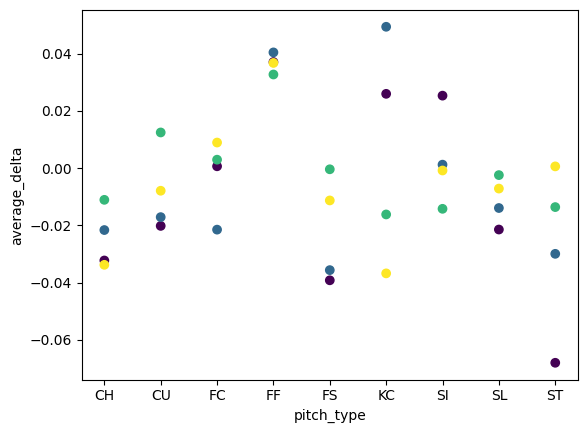

In [9]:
#scatter average_delta on y axis, pitch_type on x axis, with cluster setting the color
plt.scatter(grouped_df['pitch_type'], grouped_df['average_delta'], c=grouped_df['cluster'])
plt.xlabel('pitch_type')
plt.ylabel('average_delta')
plt.show()

In [10]:

def perform_anova_on_raw_data(df4):
    results = {}
    for pitch_type, pitch_data in df4.groupby('pitch_type'):
        clusters = pitch_data['cluster'].unique()

        # Check if there are enough clusters for ANOVA
        if len(clusters) < 2:
            results[pitch_type] = pd.DataFrame([{'f_statistic': None, 'p_value': None, "note": "less than 2 clusters"}])
            continue

        delta_groups = []
        for cluster in clusters:
            delta_values = pitch_data[pitch_data['cluster'] == cluster]['delta'].values # delta instead of average_delta
            delta_groups.append(delta_values)

        # Perform ANOVA
        try:
            f_stat, p_value = stats.f_oneway(*delta_groups)
            results[pitch_type] = pd.DataFrame([{
                'f_statistic': f_stat,
                'p_value': p_value
            }])
        except ValueError as e:
            results[pitch_type] = pd.DataFrame([{'f_statistic': None, 'p_value': None, "note": f"ValueError: {e}"}])
            print(f"ValueError for {pitch_type}: {e}")
            print(f"Delta groups: {delta_groups}")
        except Exception as e:
            results[pitch_type] = pd.DataFrame([{'f_statistic': None, 'p_value': None, "note": f"Exception: {e}"}])
            print(f"Exception for {pitch_type}: {e}")
            print(f"Delta groups: {delta_groups}")

    return results

anova_results = perform_anova_on_raw_data(df4)

formatted_data = []
for pitch_type, results_df in anova_results.items():
    if not results_df.empty:
      f_statistic = results_df['f_statistic'].iloc[0]
    p_value = results_df['p_value'].iloc[0]
    formatted_data.append({
      'pitch_type': pitch_type,
      'f_statistic': f_statistic,
      'p_value': p_value
    })
print(pd.DataFrame(formatted_data))

  pitch_type  f_statistic   p_value
0         CH     1.204603  0.308565
1         CU     1.178354  0.318766
2         FC     1.586633  0.192547
3         FF     0.302520  0.823574
4         FS     0.911835  0.438643
5         KC     1.836535  0.162605
6         SI     4.509207  0.004058
7         SL     1.140808  0.332601
8         ST     4.140283  0.007207


In [11]:

def perform_anova_on_raw_zone_data(df):
    """
    Performs ANOVA on the non-aggregated df DataFrame, grouped by zone.

    Args:
        df (pd.DataFrame): DataFrame with columns 'zone', 'cluster', and 'delta'.

    Returns:
        dict: A dictionary where keys are zones and values are DataFrames of ANOVA results.
    """
    results = {}
    for zone, zone_data in df.groupby('zone'):
        clusters = zone_data['cluster'].unique()

        # Check if there are enough clusters for ANOVA
        if len(clusters) < 2:
            results[zone] = pd.DataFrame([{'f_statistic': None, 'p_value': None, "note": "less than 2 clusters"}])
            continue

        delta_groups = []
        for cluster in clusters:
            delta_values = zone_data[zone_data['cluster'] == cluster]['delta'].values  # Corrected line
            delta_groups.append(delta_values)

        # Check for empty delta groups
        if any(len(group) == 0 for group in delta_groups):
            results[zone] = pd.DataFrame([{'f_statistic': None, 'p_value': None, "note": "Empty delta group"}])
            continue

        # Check for single unique value in delta groups
        unique_values = [np.unique(group) for group in delta_groups]
        if any(len(values) == 1 for values in unique_values):
            results[zone] = pd.DataFrame([{'f_statistic': None, 'p_value': None, "note": "One or more delta groups have only 1 unique value"}])
            continue

        # Perform ANOVA
        try:
            f_stat, p_value = stats.f_oneway(*delta_groups)
            results[zone] = pd.DataFrame([{
                'f_statistic': f_stat,
                'p_value': p_value
            }])
        except ValueError as e:
            results[zone] = pd.DataFrame([{'f_statistic': None, 'p_value': None, "note": f"ValueError: {e}"}])
            print(f"ValueError for zone {zone}: {e}")
            print(f"Delta groups: {delta_groups}")
        except Exception as e:
            results[zone] = pd.DataFrame([{'f_statistic': None, 'p_value': None, "note": f"Exception: {e}"}])
            print(f"Exception for zone {zone}: {e}")
            print(f"Delta groups: {delta_groups}")

    return results

anova_results = perform_anova_on_raw_zone_data(dfzone)

formatted_results = pd.DataFrame()
for zone, result_df in anova_results.items():
    result_df['zone'] = zone
    formatted_results = pd.concat([formatted_results, result_df], ignore_index=True)

print(formatted_results)

    f_statistic   p_value  zone
0      2.281077  0.080077   1.0
1      0.171919  0.915318   2.0
2      3.066568  0.029374   3.0
3      0.185281  0.906378   4.0
4      2.549904  0.055648   5.0
5      2.851197  0.037507   6.0
6      0.655063  0.580424   7.0
7      6.087144  0.000485   8.0
8      1.186312  0.315320   9.0
9      1.143433  0.333038  11.0
10     3.108054  0.030735  12.0
11     0.496019  0.685451  13.0
12     1.556753  0.201239  14.0


In [12]:
zone_mapping = {
        1: 'high',
        2: 'high',
        3: 'high',
        4: 'middle',
        5: 'middle',
        6: 'middle',
        7: 'low',
        8: 'low',
        9: 'low',
        11: 'up&in',
        12: 'up&away',
        13: 'low&in',
        14: 'low&away'}

dfzone['zone'] = dfzone['zone'].map(zone_mapping)

anova_results = perform_anova_on_raw_zone_data(dfzone)

formatted_results = pd.DataFrame()
for zone, result_df in anova_results.items():
    result_df['zone'] = zone
    formatted_results = pd.concat([formatted_results, result_df], ignore_index=True)

print(formatted_results)

   f_statistic   p_value      zone
0     3.053447  0.027905      high
1     4.384042  0.004508       low
2     1.556753  0.201239  low&away
3     0.496019  0.685451    low&in
4     0.503579  0.679884    middle
5     3.108054  0.030735   up&away
6     1.143433  0.333038     up&in


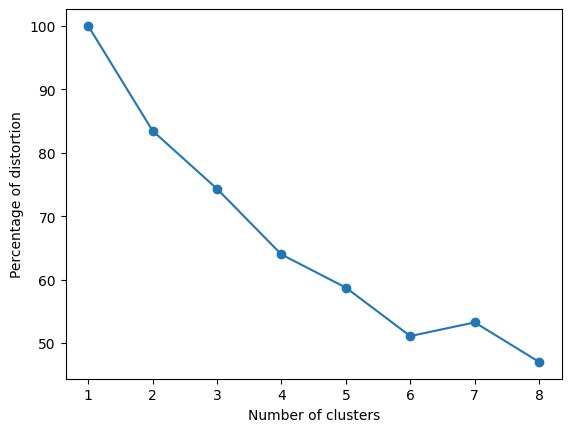

In [32]:
pitcher_zone_counts = dfpitch.groupby(['pitcher', 'remapped_zone']).size().reset_index(name='pitch_count')
pivot_df = pitcher_zone_counts.pivot(index='pitcher', columns='remapped_zone', values='pitch_count').fillna(0)
normalized_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(normalized_df)

distortions = []
for i in range(1, 9):
            kmeans = KMeans(n_clusters=i, random_state=6740, n_init='auto')
            kmeans.fit(scaled_data)
            distortions.append(kmeans.inertia_)

#plot elbow curve
max_distortion = distortions[0]
percentage_distortions = [(d / max_distortion) * 100 for d in distortions]
plt.plot(range(1, 9), percentage_distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Percentage of distortion')
plt.show()

In [36]:
kmeans = KMeans(n_clusters=6, random_state=6740, n_init=10) # Added n_init for future warning
normalized_df['cluster'] = kmeans.fit_predict(scaled_data)
normalized_df.reset_index() # Include pitcher in the output
print(normalized_df.head())

#now get xwobacon or xwoba for hitter/pitcher matchups per cluster and see if noticiable performanace difference

remapped_zone      high       low  low&away    low&in    middle   up&away  \
pitcher                                                                     
445926         0.222222  0.111111  0.444444  0.000000  0.111111  0.111111   
446372         0.155172  0.068966  0.206897  0.068966  0.224138  0.068966   
450203         0.064516  0.225806  0.387097  0.096774  0.161290  0.032258   
455119         0.176471  0.058824  0.117647  0.176471  0.235294  0.000000   
472610         0.166667  0.000000  0.166667  0.166667  0.500000  0.000000   

remapped_zone     up&in  cluster  
pitcher                           
445926         0.000000        0  
446372         0.206897        3  
450203         0.032258        0  
455119         0.235294        3  
472610         0.000000        2  


In [ ]:
# Filter data for original clusters 0 and 1
df_subset = df[df['cluster'].isin([0, 1])].copy()

# Re-scale features
subset_data = df_subset[['AA_Rnk', 'VBA']]
scaler_subset = StandardScaler()
scaled_subset = scaler_subset.fit_transform(subset_data)

# Apply K-means with 2 clusters
kmeans_subset = KMeans(n_clusters=2, random_state=6740, n_init='auto')
df_subset['new_cluster'] = kmeans_subset.fit_predict(scaled_subset)

# Plot the results
plt.scatter(df_subset['AA_Rnk'], df_subset['VBA'], c=df_subset['new_cluster'])
plt.xlabel('AA_Rnk')
plt.ylabel('VBA')
plt.title('Clusters 0 and 1 Re-analyzed (k=2)')
plt.show()
